In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import box

In [30]:

# --- Configuration Constants ---
# Paths:
INDIA_STATES_PATH = r"gadm41_IND_1.json"  # Unzipped path to India GeoJSON
INDIA_EVENT_DATA_PATH = r"crime_dataset_in.csv"  # Kaggle city-level crime dataset with city names only

# Coordinate Reference Systems (CRS):
CRS_LAT_LON = "EPSG:4326"  # WGS84 (original lat/lon)
CRS_PROJECTED = "EPSG:3857"  # Web Mercator (for plotting and metrics)

# Grid Parameters:
GRID_SIZE_KM = 50
HEATMAP_GRID_SIZE = GRID_SIZE_KM * 1000  # meters

# Plotting Configuration:
FIGURE_SIZE = (15, 12)
SAVE_DPI = 300
SAVE_FILENAME = 'india_crime_heatmap.png'


In [31]:
# --- Load and Preprocess Data ---
def geocode_city_to_latlon(df, city_column='City'):
    print("Geocoding city names to coordinates...")
    import geopy
    from geopy.geocoders import Nominatim
    from geopy.extra.rate_limiter import RateLimiter

    geolocator = Nominatim(user_agent="crime_heatmap")
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
    
    df['location'] = df[city_column].apply(geocode)
    df = df.dropna(subset=['location'])
    df['lat'] = df['location'].apply(lambda loc: loc.latitude)
    df['lon'] = df['location'].apply(lambda loc: loc.longitude)
    return df

def load_event_data():
    print("Loading crime data...")
    df = pd.read_csv(INDIA_EVENT_DATA_PATH)
    if 'lat' not in df.columns or 'lon' not in df.columns:
        df = geocode_city_to_latlon(df, city_column='City')
    df = df.dropna(subset=['lon', 'lat'])
    gdf = gpd.GeoDataFrame(df,
        geometry=gpd.points_from_xy(df['lon'], df['lat']),
        crs=CRS_LAT_LON).to_crs(CRS_PROJECTED)
    return gdf

def load_india_states():
    print("Loading India state boundaries...")
    states_gdf = gpd.read_file(INDIA_STATES_PATH).to_crs(CRS_PROJECTED)
    return states_gdf

In [32]:
# --- Load and Compute Bounding Box ---
gdf = load_event_data()
states_gdf = load_india_states()

# Calculate bounds dynamically from shapefile
minx, miny, maxx, maxy = states_gdf.total_bounds
PAD = 50000  # Add 50 km padding
BOUNDS_MIN_X = minx - PAD
BOUNDS_MAX_X = maxx + PAD
BOUNDS_MIN_Y = miny - PAD
BOUNDS_MAX_Y = maxy + PAD

# Clip data to India extent
clip_box = box(BOUNDS_MIN_X, BOUNDS_MIN_Y, BOUNDS_MAX_X, BOUNDS_MAX_Y)
gdf = gdf[gdf.geometry.within(clip_box)].copy()
states_clipped = gpd.clip(states_gdf, clip_box)


Loading crime data...


FileNotFoundError: [Errno 2] No such file or directory: 'crime_dataset_in.csv'

In [33]:
# --- Heatmap Generation ---
print("Generating heatmap bins...")
x_bins = np.arange(BOUNDS_MIN_X, BOUNDS_MAX_X + HEATMAP_GRID_SIZE, HEATMAP_GRID_SIZE)
y_bins = np.arange(BOUNDS_MIN_Y, BOUNDS_MAX_Y + HEATMAP_GRID_SIZE, HEATMAP_GRID_SIZE)

print("Computing 2D histogram...")
heatmap, x_edges, y_edges = np.histogram2d(
    gdf.geometry.x, gdf.geometry.y, bins=[x_bins, y_bins])


Generating heatmap bins...


NameError: name 'BOUNDS_MIN_X' is not defined

Plotting results...


NameError: name 'heatmap' is not defined

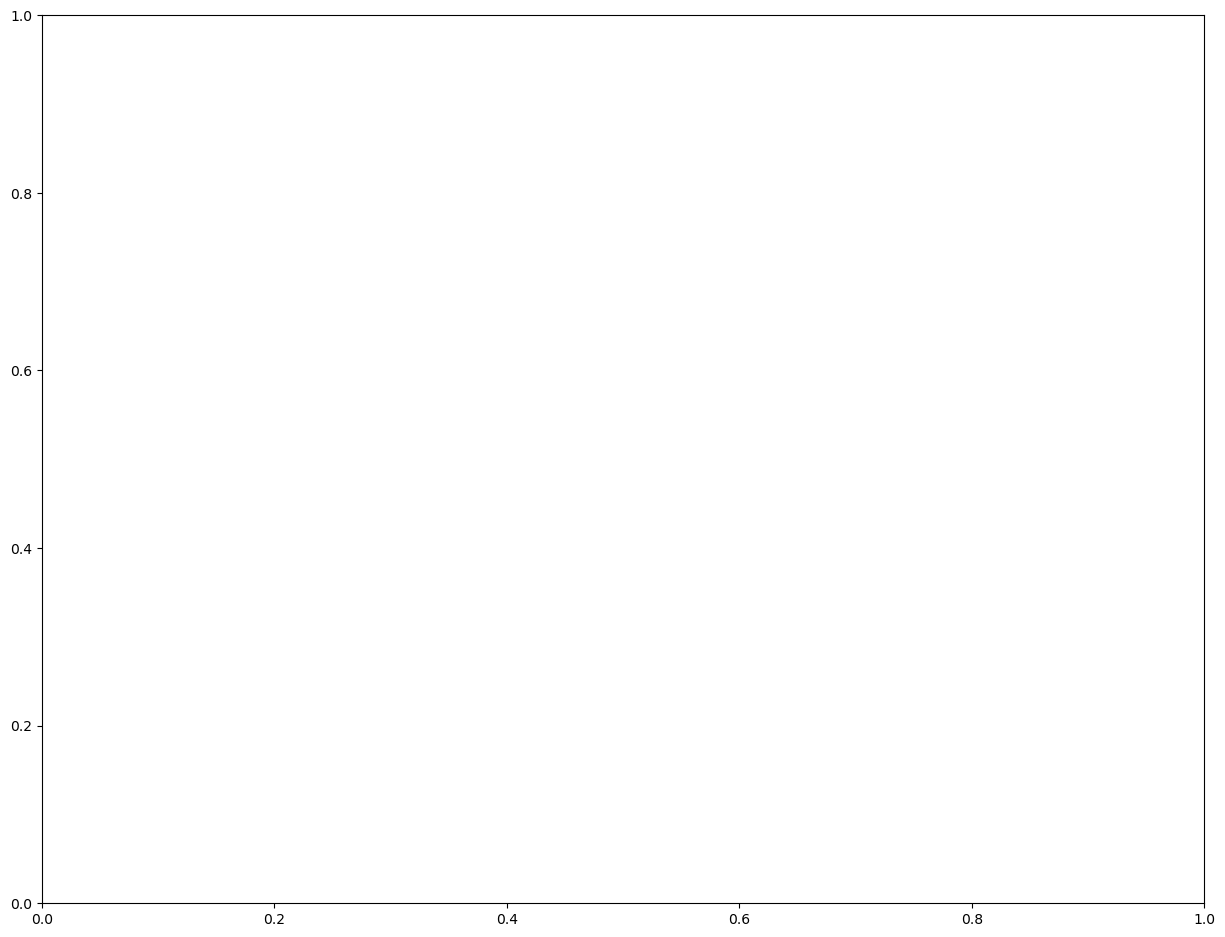

In [34]:
# --- Plotting ---
print("Plotting results...")
fig, ax = plt.subplots(figsize=FIGURE_SIZE)
fig.subplots_adjust(top=0.85)

# Plot heatmap first
vmax = np.max(heatmap)
img = ax.imshow(
    heatmap.T,
    extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]],
    origin='lower', cmap=plt.cm.hot, vmin=0, vmax=vmax, aspect='auto')

# Overlay state boundaries
states_clipped.boundary.plot(ax=ax, color='white', linewidth=1)

# Annotations
plt.text(BOUNDS_MIN_X, BOUNDS_MAX_Y + PAD, 'India Crime Density Heatmap',
         fontsize=22, fontweight='bold', ha='left')
plt.text(BOUNDS_MIN_X, BOUNDS_MAX_Y + PAD/2,
         f'{GRID_SIZE_KM}x{GRID_SIZE_KM} km grid cells', fontsize=14, ha='left')

# Source Label
plt.text(BOUNDS_MIN_X + PAD, BOUNDS_MIN_Y + PAD,
         'Source: Kaggle Indian Crimes Dataset', fontsize=11, color='white', fontstyle='italic')

# Cleanup axes
ax.axis('off')

# Colorbar
ticks = np.linspace(0, vmax, 6, dtype=int)
cbar = plt.colorbar(img, ax=ax, shrink=0.6, ticks=ticks)
cbar.set_label('\nCrime Count per Grid Cell', fontsize=14)
cbar.ax.set_yticklabels(list(map(str, ticks)))

# Save and Show
plt.savefig(SAVE_FILENAME, dpi=SAVE_DPI, bbox_inches='tight')
print(f"Plot saved as {SAVE_FILENAME}")
plt.show()
